# 데이터 전처리 및 병합

In [1]:
# 라이브러리
import pandas as pd
import numpy as np
import json
from collections import defaultdict
from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm

C:\Users\mbs95\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. 파일 불러오기
stat_df = pd.read_csv("./dataset/csv/level_125_statOnly.csv")

with open("./dataset/skill_ships.json", "r", encoding="utf-8") as f:
    skill_data = json.load(f)

with open("./dataset/roles_ships.json", "r", encoding="utf-8") as f:
    roles_data = json.load(f)

In [3]:
# 2. skill_ships.json → 캐릭터 이름 기준으로 스킬 설명 모으기
ship_skills = defaultdict(list)
for skill in skill_data:
    description = skill.get("Description", "")
    for ship in skill.get("Ships", []):
        ship_skills[ship.strip()].append(description)

# 캐릭터별 스킬 설명을 하나의 텍스트로 결합
ship_skill_text = {ship: " ".join(descs) for ship, descs in ship_skills.items()}
skill_df = pd.DataFrame(list(ship_skill_text.items()), columns=["Name", "Skill_Description"])

In [4]:
# 3. roles_ships.json → 캐릭터 이름과 전/후열 구분, Role 추출
roles_df = pd.DataFrame(roles_data)
roles_df = roles_df[["Name", "Fleet", "Roles"]].copy()
roles_df["Role"] = roles_df["Roles"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
roles_df.drop(columns=["Roles"], inplace=True)

In [5]:
# 3-1. statonly.csv-> 영향을 미치지 않는 스테이터스 제외
stat_df.drop(columns=["Nation"], inplace=True)
stat_df.drop(columns=["Type"], inplace=True)
stat_df.drop(columns=["Luck"], inplace=True)
stat_df.drop(columns=["ArmorType"], inplace=True)

In [6]:
# 4. 데이터 정리: 이름 공백 제거
stat_df["Name"] = stat_df["Name"].str.strip()
skill_df["Name"] = skill_df["Name"].str.strip()
roles_df["Name"] = roles_df["Name"].str.strip()

In [7]:
# 5. 데이터 병합 및 후처리
merged_df = stat_df.merge(skill_df, on="Name", how="inner")
merged_df = merged_df.merge(roles_df, on="Name", how="inner")
merged_df = merged_df.drop(columns="Unnamed: 0")
# print(merged_df)

In [8]:
# 병합 데이터 파일 백업
title=f"./dataset/dataset_ships.json"
merged_df.to_csv(title, encoding="utf-8-sig") # utf-8-sig: 특수문자 깨짐 방지

# 스킬 설명 벡터화 및 수치형 데이터와의 결합

In [9]:
# 5. BERT 임베딩 (스킬 설명)
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
bert_model = BertModel.from_pretrained("bert-base-multilingual-cased")
bert_model.eval()

def get_bert_embeddings(text_list, batch_size=16):
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="BERT Embedding"):
        batch = text_list[i:i+batch_size]
        encoded = tokenizer(batch, padding=True, truncation=True, return_tensors="pt", max_length=128)
        with torch.no_grad():
            output = bert_model(**encoded)
        cls_embeddings = output.last_hidden_state[:, 0, :].numpy()
        embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

descriptions = merged_df["Skill_Description"].fillna("").tolist()
bert_embeddings = get_bert_embeddings(descriptions)

BERT Embedding: 100%|██████████| 19/19 [00:15<00:00,  1.20it/s]


In [10]:
# 6. 수치형 데이터 결합
numeric_features = merged_df.select_dtypes(include=[np.number])
numeric_array = numeric_features.drop(columns=["Unnamed: 0"], errors="ignore").to_numpy()
X_combined = np.hstack([bert_embeddings, numeric_array])
y_labels = merged_df["Role"].values

In [11]:
# 7. 결과 확인
print("✅ 임베딩 완료!")
print("🔸 입력 벡터 형태:", X_combined.shape)
print("🔸 라벨 개수:", len(y_labels))
print("🔸 고유 Role 목록:", np.unique(y_labels))

✅ 임베딩 완료!
🔸 입력 벡터 형태: (292, 777)
🔸 라벨 개수: 292
🔸 고유 Role 목록: ['DamageCV' 'DamageDealer' 'Flagship' 'Off-Flag' 'Support' 'Tank']


# 모델 학습

## 문제 정의 요약
입력: 텍스트(BERT 임베딩) + 수치형 능력치

출력: Role (Support, Flagship, Off-Flag, DamageCV 등 → 다중 클래스 분류)

데이터 크기: 수백 개 단위 (추정)

특성 차원: BERT(768차원) + 수치형 수십 개 = 약 800~850차원

클래스 불균형 있음

## 추천 분류 모델 Top 3

1. LightGBM
✅ 장점: 적은 데이터에도 잘 작동, 학습 속도 빠름, 특성 중요도 파악 가능

⚠️ 단점: 고차원 희소 특성에는 성능이 살짝 떨어질 수 있음

💡 추천: 가볍고 빠른 실험, 해석도 함께 하고 싶을 때

2. MLPClassifier (다층 퍼셉트론, PyTorch or scikit-learn)
✅ 장점: BERT 임베딩처럼 연속 벡터 특성에 잘 맞음

⚠️ 단점: 하이퍼파라미터 튜닝 필요, 과적합 조심

💡 추천: 종단 간 딥러닝 방식을 원할 때

3. Logistic Regression (softmax)
✅ 장점: 가장 기본적인 선형 모델, 빠름

⚠️ 단점: 비선형 문제에서 성능 낮음

💡 추천: 기준선(Base line) 설정용

## 결론
MLPClassifier (PyTorch 기반)
이유: BERT 임베딩이 고차원 연속 벡터이므로, 신경망 기반 분류기가 가장 잘 맞습니다.

In [12]:
import sklearn
print(sklearn.__version__)

1.6.1


In [12]:
# 라이브러리
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [13]:
# 1. 라벨 인코딩
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_labels)
num_classes = len(label_encoder.classes_)

In [14]:
# 2. 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [15]:
# 3. 텐서 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [16]:
# 4. 모델 정의 (MLP)
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim // 2, output_dim)
        )

    def forward(self, x):
        return self.model(x)

model = MLPClassifier(X_train.shape[1])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [17]:
# 5. 학습 준비
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
batch_size = 32

In [18]:
# 6. 학습 루프
for epoch in range(epochs):
    model.train()
    perm = torch.randperm(X_train_tensor.size(0))
    sum_loss = 0
    for i in range(0, X_train_tensor.size(0), batch_size):
        idx = perm[i:i+batch_size]
        x_batch = X_train_tensor[idx].to(device)
        y_batch = y_train_tensor[idx].to(device)

        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()

    avg_loss = sum_loss / (X_train_tensor.size(0) // batch_size)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}")

Epoch 1/20 - Loss: 45.6779
Epoch 2/20 - Loss: 21.4517
Epoch 3/20 - Loss: 9.3222
Epoch 4/20 - Loss: 6.8810
Epoch 5/20 - Loss: 3.8229
Epoch 6/20 - Loss: 2.5768
Epoch 7/20 - Loss: 1.8796
Epoch 8/20 - Loss: 1.7521
Epoch 9/20 - Loss: 1.7445
Epoch 10/20 - Loss: 1.7438
Epoch 11/20 - Loss: 1.7187
Epoch 12/20 - Loss: 1.7720
Epoch 13/20 - Loss: 1.5471
Epoch 14/20 - Loss: 1.6734
Epoch 15/20 - Loss: 1.5961
Epoch 16/20 - Loss: 1.4744
Epoch 17/20 - Loss: 1.6027
Epoch 18/20 - Loss: 1.5717
Epoch 19/20 - Loss: 1.4372
Epoch 20/20 - Loss: 1.5786


In [19]:
# 7. 평가
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device))
    y_pred_labels = torch.argmax(y_pred, dim=1).cpu().numpy()
    y_true_labels = y_test_tensor.numpy()

print("\n📊 분류 리포트:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))



📊 분류 리포트:
              precision    recall  f1-score   support

    DamageCV       0.73      1.00      0.84         8
DamageDealer       0.64      0.89      0.74        18
    Flagship       0.00      0.00      0.00         5
    Off-Flag       0.41      1.00      0.58         9
     Support       1.00      0.10      0.18        10
        Tank       0.00      0.00      0.00         9

    accuracy                           0.58        59
   macro avg       0.46      0.50      0.39        59
weighted avg       0.53      0.58      0.46        59



C:\Users\mbs95\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mbs95\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\mbs95\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

# 모델 수정(Modification)

## confusion matrix

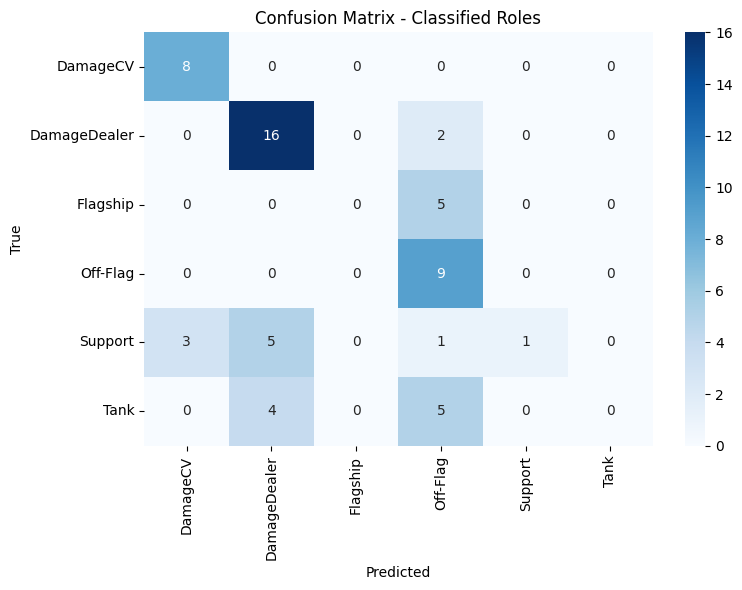

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 혼동 행렬 계산
cm = confusion_matrix(y_true_labels, y_pred_labels)

# 2. 라벨 이름 (클래스 이름)
class_names = label_encoder.classes_

# 3. 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Classified Roles")
plt.tight_layout()
plt.show()


## 예측 결과 확인

In [23]:
# 캐릭터 이름, 실제 역할, 예측 역할 확인용 테이블 만들기
import pandas as pd

# test 인덱스 추적용
_, X_test_idx = train_test_split(
    merged_df.reset_index(), test_size=0.2, random_state=42, stratify=y_encoded
)

# index 순서 복원
X_test_idx = X_test_idx.reset_index(drop=True)

# 예측 결과 매핑
result_df = pd.DataFrame({
    "Name": X_test_idx["Name"],
    "True Role": label_encoder.inverse_transform(y_true_labels),
    "Predicted Role": label_encoder.inverse_transform(y_pred_labels)
})

# 잘못 예측된 것만 확인 (선택)
mismatched = result_df[result_df["True Role"] != result_df["Predicted Role"]]

# 전체 결과 보기
# print("전체 예측 결과:")
# print(result_df)

# 또는 잘못된 것만 보기
print("\n❌ 잘못된 예측만:")
print(mismatched)

mismatched.to_json("model_prediction_fault.json", orient="records", force_ascii=False, indent=2)



❌ 잘못된 예측만:
                       Name     True Role Predicted Role
0                    Napoli          Tank       Off-Flag
2              Jeanne d'Arc       Support   DamageDealer
3                  Cheshire          Tank   DamageDealer
6                      Zara          Tank       Off-Flag
8                    Nagato      Flagship       Off-Flag
9   Kasumi (Venus Vacation)          Tank   DamageDealer
12               Washington      Flagship       Off-Flag
16                  Ryuuhou       Support       DamageCV
22                 Yukikaze          Tank   DamageDealer
23                  Kashino       Support       Off-Flag
24             Akane Shinjo      Flagship       Off-Flag
26                 Painlevé       Support       DamageCV
27                Baltimore  DamageDealer       Off-Flag
28                     Roon          Tank       Off-Flag
29                  Neptune          Tank   DamageDealer
34           Stephen Potter       Support   DamageDealer
39                 